In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm
import seaborn as sb
from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random

In [146]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

In [147]:
datos=pd.read_csv("movies.csv", encoding="latin1")

## Revisión de datos

El clustering se va a enfocar en las columnas cuantitativas, es por ello vamos a examinar los datos e identificar las que son útiles para hacerlo.

In [148]:
datos['actorsPopularityAvg'] = (
    datos['actorsPopularity']
    .astype(str)  # Convierte todo a string para evitar errores
    .str.split('|')  # Divide en listas
    .apply(lambda x: np.mean([float(i) for i in x if i.replace('.', '', 1).isdigit()]))  # Convierte y promedia
)

datos.fillna({'actorsPopularityAvg': 0.0}, inplace=True)

c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [149]:
columnas_cuantitativas = datos.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(datos[columnas_cuantitativas].describe())  # Variables con varianza baja pueden ser eliminadas


                  id        budget       revenue       runtime    popularity  \
count   10000.000000  1.000000e+04  1.000000e+04  10000.000000  10000.000000   
mean   249876.829300  1.855163e+07  5.673793e+07    100.268100     51.393907   
std    257380.109004  3.662669e+07  1.495854e+08     27.777829    216.729552   
min         5.000000  0.000000e+00  0.000000e+00      0.000000      4.258000   
25%     12286.500000  0.000000e+00  0.000000e+00     90.000000     14.577750   
50%    152558.000000  5.000000e+05  1.631245e+05    100.000000     21.905500   
75%    452021.750000  2.000000e+07  4.479661e+07    113.000000     40.654000   
max    922260.000000  3.800000e+08  2.847246e+09    750.000000  11474.647000   

            voteAvg     voteCount  genresAmount  productionCoAmount  \
count  10000.000000  10000.000000  10000.000000        10000.000000   
mean       6.483490   1342.381800      2.596500            3.171400   
std        0.984274   2564.196637      1.154565            2.53973

In [ ]:
# Creamos grupos a evaluar
Groups_names = ['financiero', 'popularidad', 'duracion', 'reparto']

X1 = datos[['budget', 'revenue', 'voteCount']]
X2 = datos[['voteAvg', 'revenue', 'popularity']]
X3 = datos[['runtime', 'revenue']]
X4 = datos[['actorsPopularityAvg', 'revenue', 'actorsAmount']]

In [181]:
# Escalar los grupos
# Fijar la semilla para obtener resultados reproducibles
random.seed(123)

# Escalar los datos para normalización
financiero = sklearn.preprocessing.scale(X1)
popularidad = sklearn.preprocessing.scale(X2)
producción = sklearn.preprocessing.scale(X3)
reparto = sklearn.preprocessing.scale(X4)

Groups = [financiero, popularidad, producción, reparto]

## Tendencia del Agrupamiento

#### Estadístico Hopkins

In [182]:
# Calcular la estadística de Hopkins
for i in range(len(Groups)):
    hopkins_stat = pyclustertend.hopkins(Groups[i], len(Groups[i]))
    print(f'Estadística de Hopkins para grupo {i+1} -> {Groups_names[i]}: {hopkins_stat}')

Estadística de Hopkins para grupo 1 -> financiero: 0.020543835482211666
Estadística de Hopkins para grupo 2 -> popularidad: 0.005354944548880564
Estadística de Hopkins para grupo 3 -> duracion: 0.002544941380687201
Estadística de Hopkins para grupo 4 -> reparto: 0.002385683395933523


#### VAT

In [ ]:
# Al ser demasiados datos, omitimos este paso
# # for group in Groups:
#     pyclustertend.vat(group)

## ¿Cuántos grupos formamos?
#### Gráfico de codo

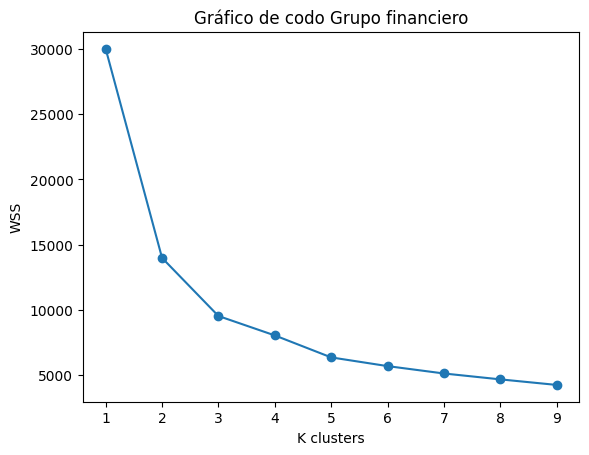

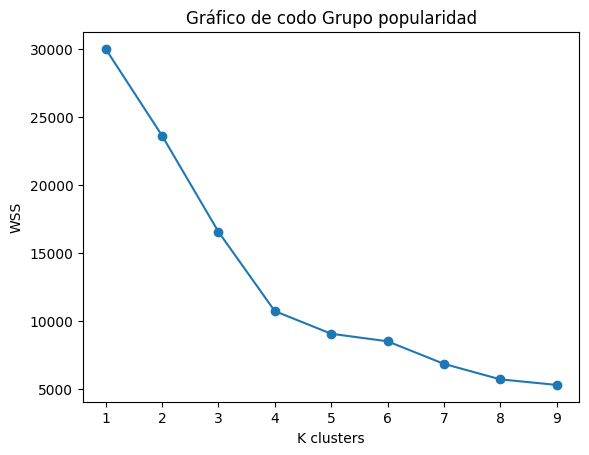

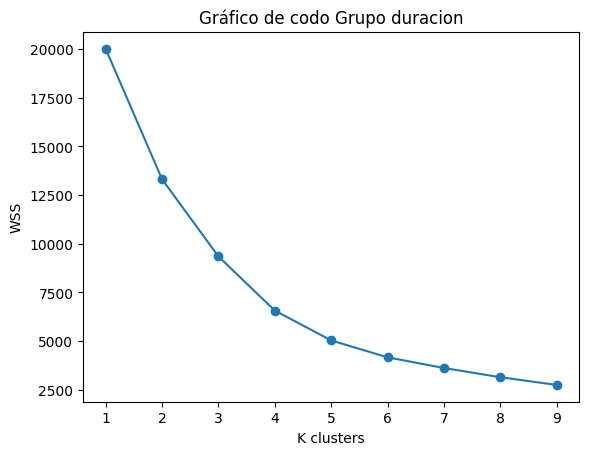

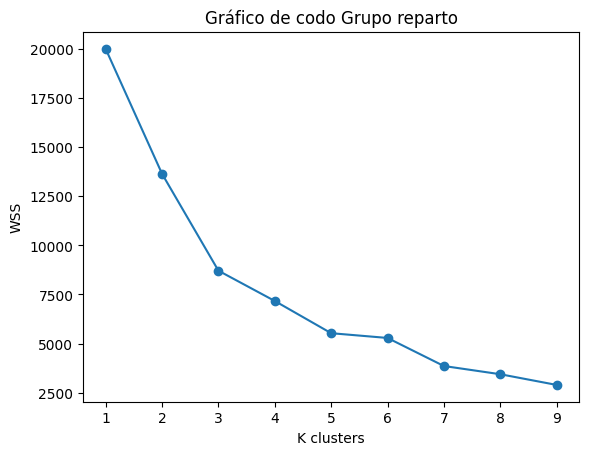

In [186]:
numeroClusters = range(1,10)

for j in range(len(Groups)):
    wcss = []
    for i in numeroClusters:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(Groups[j])
        wcss.append(kmeans.inertia_)

    plt.plot(numeroClusters, wcss, marker='o')
    plt.xticks(numeroClusters)
    plt.xlabel("K clusters")
    plt.ylabel("WSS")
    plt.title(f'Gráfico de codo Grupo {Groups_names[j]}')
    plt.show()

In [189]:
k_clusters = [3, 3, 5, 3]

## Agrupación

#### K-means

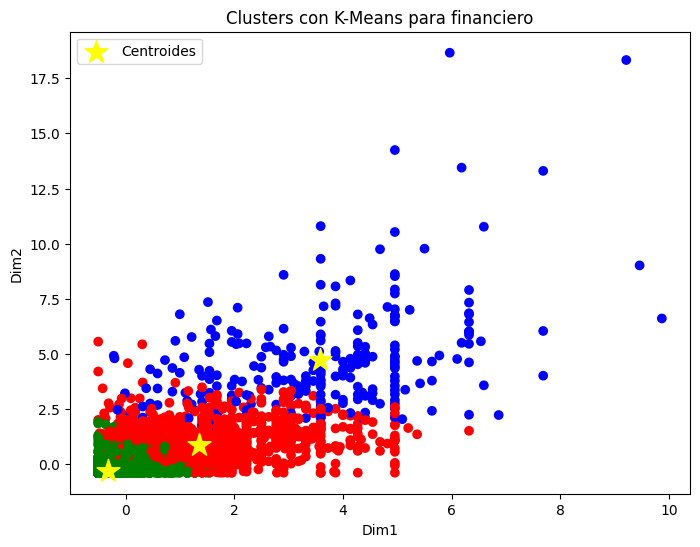

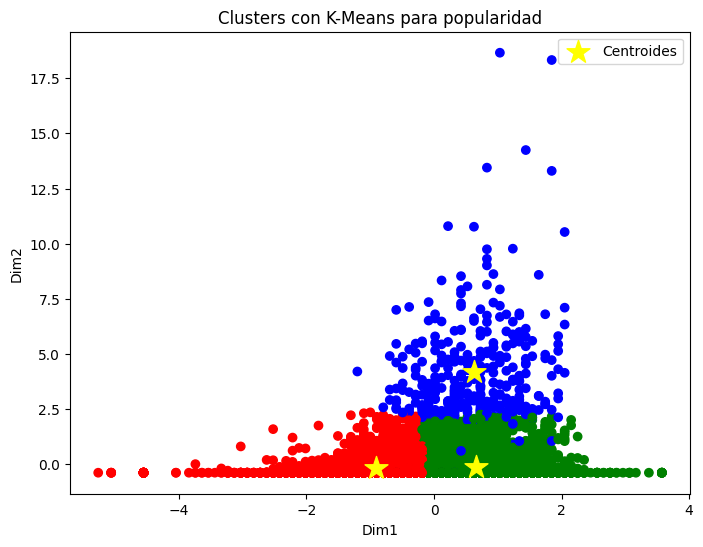

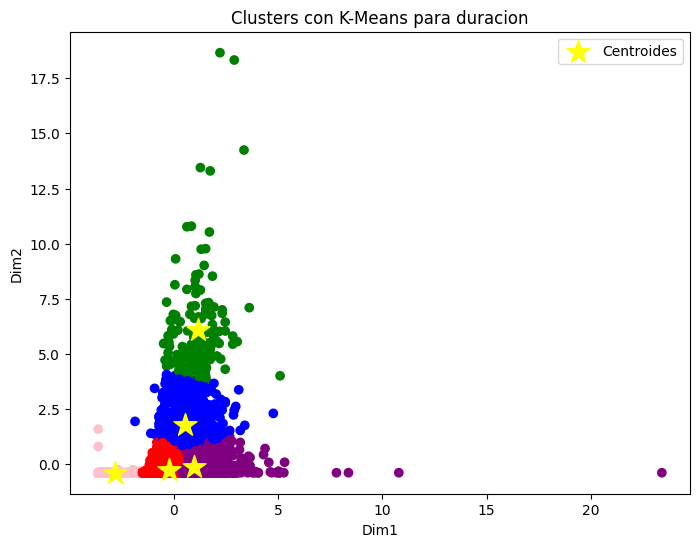

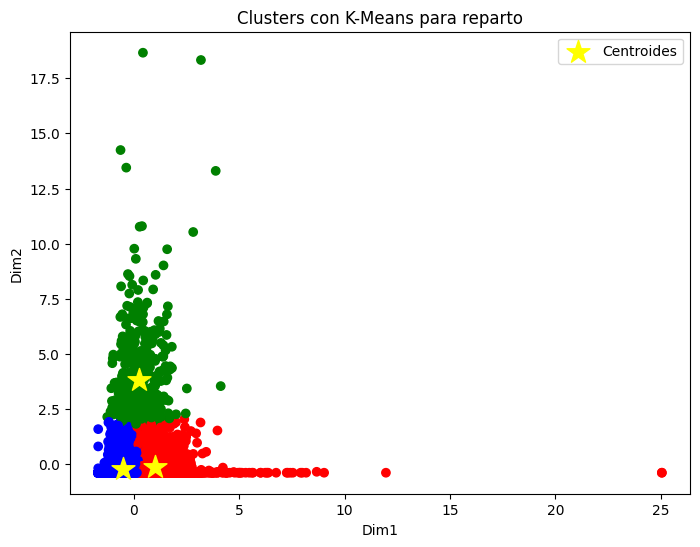

In [190]:
colores = np.array(['red', 'blue', 'green', 'pink', 'purple', 'orange'])

for i, group in enumerate(Groups):
    km = KMeans(n_clusters=k_clusters[i]).fit(group)

    especies = km.labels_ 
    centroides = km.cluster_centers_

    # Graficar los clusters
    plt.figure(figsize=(8, 6))

    plt.scatter(group[:, 0], group[:, 1], c=colores[especies])
    plt.xlabel('Dim1')
    plt.ylabel('Dim2');

    # Graficar centroides en amarillo
    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, c="yellow", marker="*", label="Centroides")

    plt.title(f"Clusters con K-Means para {Groups_names[i]}")
    plt.legend()
    plt.show()

#### Clustering Jerárquico

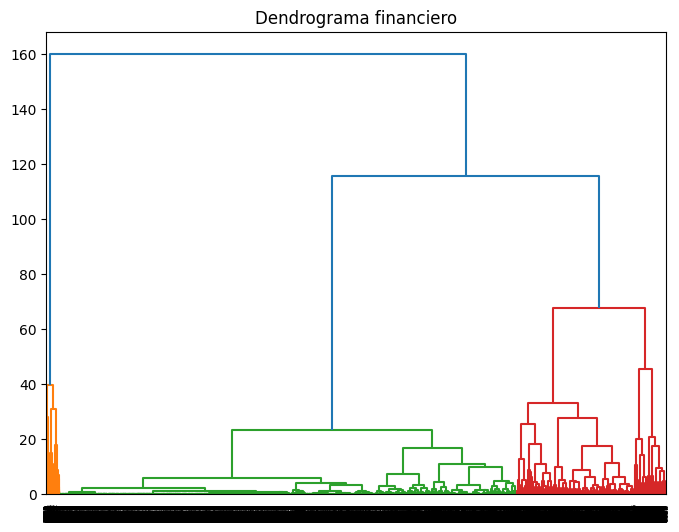

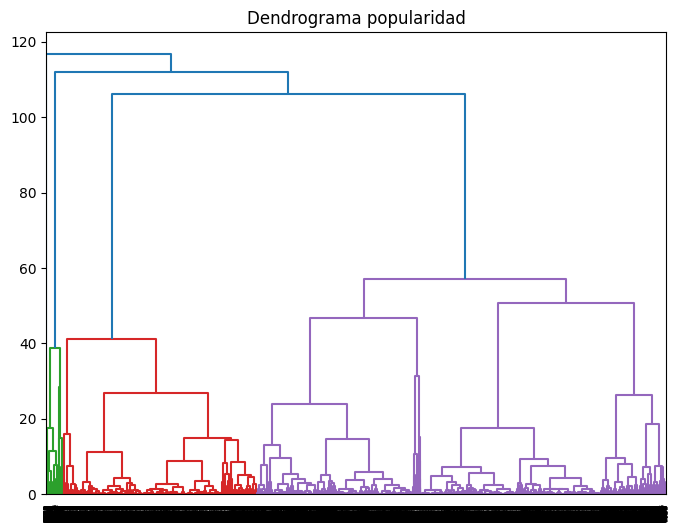

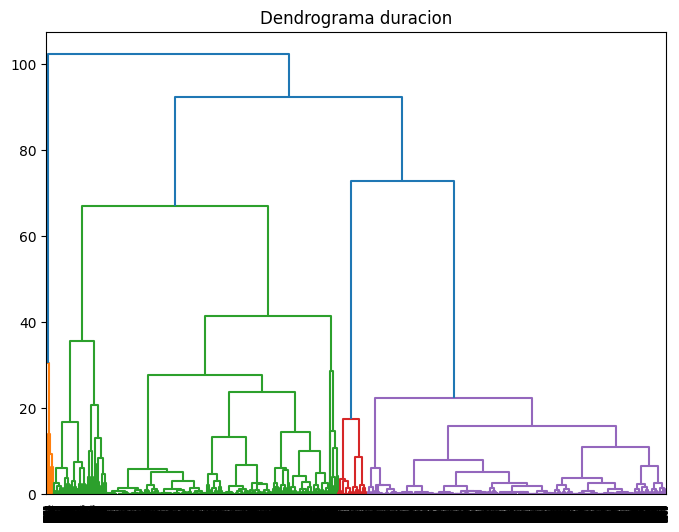

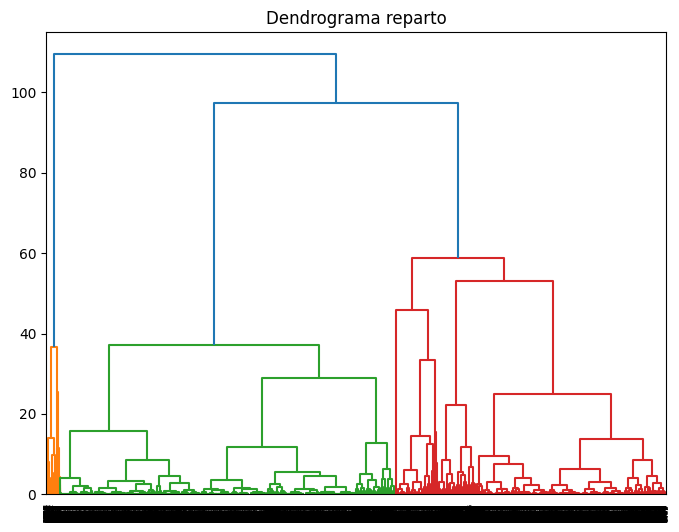

In [191]:
for i, group in enumerate(Groups):
    plt.figure(figsize=(8, 6))  # Crea una nueva figura para cada dendograma
    plt.title(f'Dendrograma {Groups_names[i]}')
    sch.dendrogram(sch.linkage(group, method='ward'))
    plt.show() 

## Análisis de Silhoutte

For n_clusters = 3 The average silhouette_score is : 0.7011339878103104


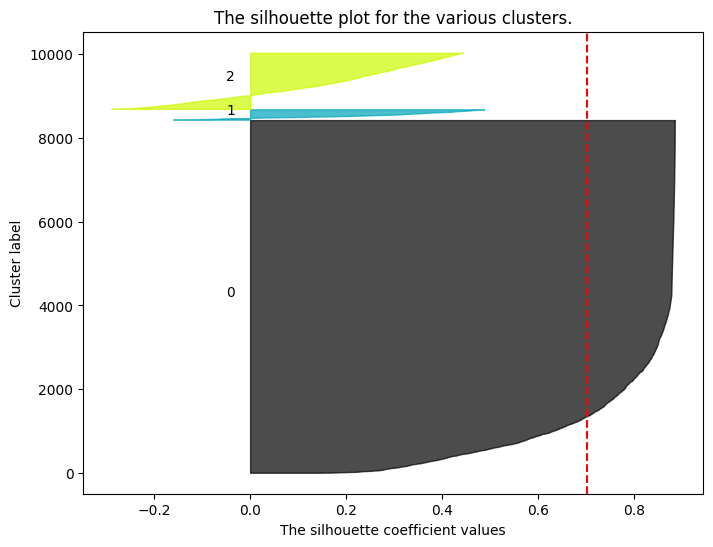

For n_clusters = 4 The average silhouette_score is : 0.4305879611842733


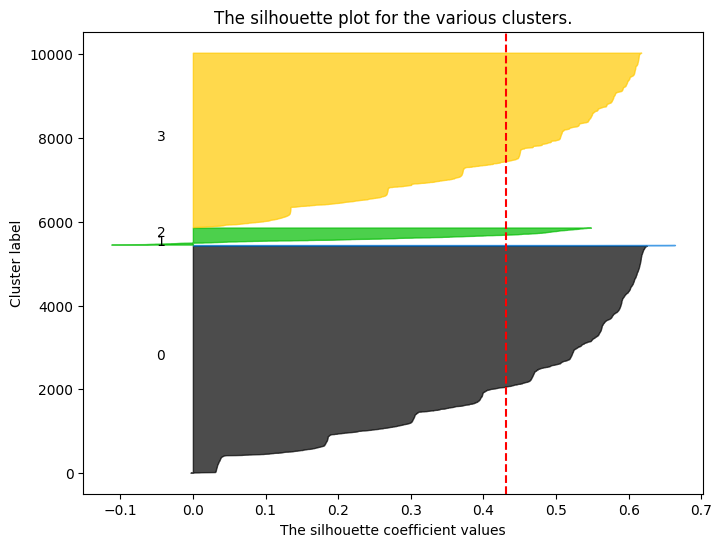

For n_clusters = 5 The average silhouette_score is : 0.5100142032255048


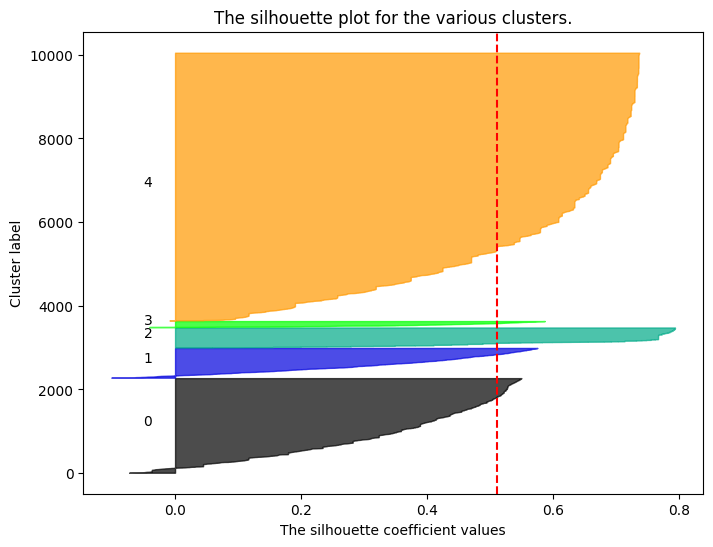

For n_clusters = 3 The average silhouette_score is : 0.47954022608253627


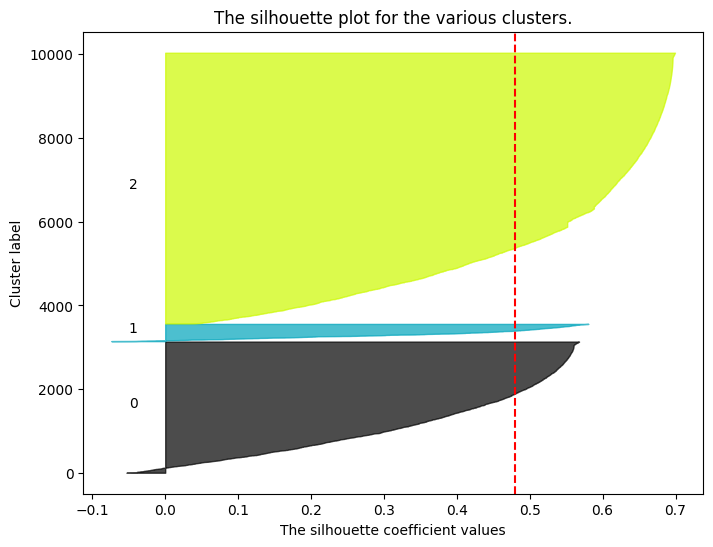

In [179]:
for i, group in enumerate(Groups):
    plt.figure(figsize=(8, 6))
    n_clusters = k_clusters[i]

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(group)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(group, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(group, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()